# モジュール

In [1]:
import os
import pickle
import numpy as np
from tqdm import tqdm
from time import sleep
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt
%matplotlib inline

# モデルの定義

## Generator
なんてことないベーシックなGenerator

In [2]:

class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(64, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            
            nn.Linear(1024, 128 * 8 * 8),
            nn.BatchNorm1d(128 * 8 * 8),
            nn.ReLU(),
        )
        
        # 128x8x8
        self.deconv = nn.Sequential(
            #nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1), # -> 128x8x8
            nn.ConvTranspose2d(128, 128, kernel_size=1, stride=1, padding=0), # -> 128x8x8
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # -> 64x16x16
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1), # -> 3x32x32
            nn.BatchNorm2d(3),
            nn.Sigmoid(),
        )
        
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, 8, 8)
        x = self.deconv(x)
        return x

## Discriminator
VDB要素がある。処理自体はVAEのDecoderとEncoderの間と同じ。

1. 入力画像を畳み込み => x
2. xを２つ畳み込み => mean, logvar
3. 標準正規分布からmeanと同じサイズのランダム出力 => noize
4. 潜在変数を次の式から算出 $noize\times e^{\frac{logvar}{2}}+mean$ => z
5. 全結合層にzを入力 => x'

出力：x', mean, logvar


In [3]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # 3x32x32
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1), # -> 64x16x16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # -> 128x8x8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            #nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1), # -> 128x4x4
            nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0), # -> 128x8x8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * 8 * 8, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
        
        # -------------------------------- VDB
        self.conv_mean = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0) # -> 128x8x8
        self.conv_logvar = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0) # -> 128x8x8
        # --------------------------------
        
        initialize_weights(self)
    
    def forward(self, input):
        x = self.conv(input)
        
        # -------------------------------- VDB
        mean = self.conv_mean(x).view(-1, 128 * 8 * 8)
        logvar = self.conv_logvar(x).view(-1, 128 * 8 * 8)
        noise = torch.randn(mean.size(), device=device)
        z = (0.5 * logvar).exp() * noise + mean
        # --------------------------------
        
        x = self.fc(z)
        return x, mean, logvar

## 重みの初期化

In [4]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

# 学習訓練

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
def train(D, G, D_criterion, G_criterion, D_optimizer, G_optimizer, data_loader, beta):

    y_real = torch.ones(batch_size, 1)
    y_fake = torch.zeros(batch_size, 1)
    
    y_real = y_real.to(device)
    y_fake = y_fake.to(device)

    D_running_loss = 0
    G_running_loss = 0
    
    for batch_idx, (real_images, _) in enumerate(tqdm(data_loader)):
        # 学習モードに切り替え
        D.train()  
        G.train()
        
        z = torch.rand((batch_size, z_dim))
        real_images, z = real_images.to(device), z.to(device)
        
        # ----------------------------------------------------------------
        # Discriminator update
        # ----------------------------------------------------------------
        D_optimizer.zero_grad()

        # D train on real images
        D_real, mean, logvar = D(real_images)
        D_real_loss, loss_kldiv_real = D_criterion(D_real, y_real, mean, logvar, beta)

        # D train on fake images
        fake_images = G(z)
        D_fake, mean, logvar = D(fake_images.detach()) # ここはdetach?
        D_fake_loss, loss_kldiv_fake = D_criterion(D_fake, y_fake, mean, logvar, beta)

        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()
        D_running_loss += D_loss.item()

        # -------------------------------- VDB
        loss_kldiv = loss_kldiv_real.item() + loss_kldiv_fake.item()
        beta = max(0.0, beta + alpha * loss_kldiv)
        # -------------------------------- 
        
        # ----------------------------------------------------------------
        # Generator update
        # ----------------------------------------------------------------
        z = torch.rand((batch_size, z_dim))
        z = z.to(device)

        G_optimizer.zero_grad()

        fake_images = G(z)
        
        D_fake, mean, logvar = D(fake_images)
        G_loss = G_criterion(D_fake, y_real)
        
        G_loss.backward()
        G_optimizer.step()
        G_running_loss += G_loss.item()
        
        
    D_running_loss /= len(data_loader)
    G_running_loss /= len(data_loader)
    
    return D_running_loss, G_running_loss, beta

In [7]:
def generate(G):
    G.eval()

    sample_z = torch.rand((25, z_dim))
    sample_z = sample_z.to(device)
    
    with torch.no_grad():
        images = G(sample_z).to('cpu')
        plt.imshow(np.transpose(make_grid(images, nrow=5, padding=1).numpy(),(1, 2, 0)))
        plt.axis('off')
        plt.show()

In [8]:
# hyperparameters
batch_size = 128
lr = 0.0002
z_dim = 64
num_epochs = 100
sample_num = 16
log_dir = './logs/vgan-cifar10'

In [9]:
# load dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = datasets.CIFAR10('data/cifar10', train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10


(-0.5, 165.5, 165.5, -0.5)

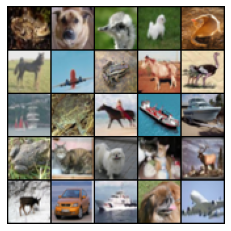

In [10]:
images, labels = iter(data_loader).next()
images, labels = images[:25], labels[:25]
plt.imshow(np.transpose(make_grid(images, nrow=5, padding=1).numpy(),(1, 2, 0)))
plt.axis('off')

In [11]:
G = Generator().to(device)
D = Discriminator().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# -------------------------------- VDB
I_c = 0.1
beta = 0 #1.0
alpha = 1e-5

def VDB_loss(out, label, mean, logvar, beta):
    normal_D_loss = torch.mean(F.binary_cross_entropy(out, label))
    
    kldiv_loss = - 0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())
    kldiv_loss = kldiv_loss.mean() - I_c
    final_loss = normal_D_loss + beta * kldiv_loss
    
    return final_loss, kldiv_loss.detach()
# --------------------------------

G_criterion = nn.BCELoss()
D_criterion = VDB_loss

100%|██████████| 390/390 [08:20<00:00,  1.28s/it]


epoch 1, D_loss: 1.3942 G_loss: 0.6969


100%|██████████| 390/390 [08:29<00:00,  1.31s/it]


epoch 2, D_loss: 1.2498 G_loss: 0.9195


100%|██████████| 390/390 [08:24<00:00,  1.29s/it]


epoch 3, D_loss: 1.3244 G_loss: 0.8193


100%|██████████| 390/390 [08:49<00:00,  1.36s/it]


epoch 4, D_loss: 1.3596 G_loss: 0.7630


100%|██████████| 390/390 [08:19<00:00,  1.28s/it]

epoch 5, D_loss: 1.3745 G_loss: 0.7309


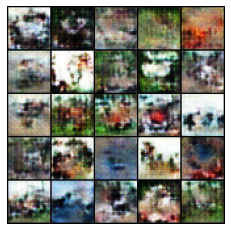

100%|██████████| 390/390 [08:15<00:00,  1.27s/it]


epoch 6, D_loss: 1.3643 G_loss: 0.7482


100%|██████████| 390/390 [08:19<00:00,  1.28s/it]


epoch 7, D_loss: 1.3404 G_loss: 0.7838


100%|██████████| 390/390 [08:18<00:00,  1.28s/it]


epoch 8, D_loss: 1.3192 G_loss: 0.8237


100%|██████████| 390/390 [08:17<00:00,  1.27s/it]


epoch 9, D_loss: 1.2918 G_loss: 0.8674


100%|██████████| 390/390 [08:17<00:00,  1.28s/it]

epoch 10, D_loss: 1.2518 G_loss: 0.9217


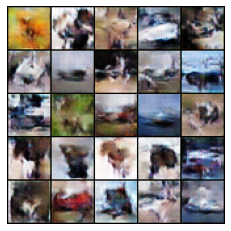

100%|██████████| 390/390 [08:23<00:00,  1.29s/it]


epoch 11, D_loss: 1.1939 G_loss: 1.0185


100%|██████████| 390/390 [08:15<00:00,  1.27s/it]


epoch 12, D_loss: 1.1618 G_loss: 1.0688


100%|██████████| 390/390 [08:25<00:00,  1.30s/it]


epoch 13, D_loss: 1.1515 G_loss: 1.1076


100%|██████████| 390/390 [08:40<00:00,  1.34s/it]


epoch 14, D_loss: 1.1288 G_loss: 1.1342


100%|██████████| 390/390 [08:36<00:00,  1.32s/it]

epoch 15, D_loss: 1.1174 G_loss: 1.1764


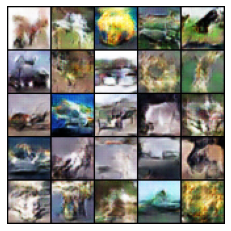

100%|██████████| 390/390 [08:47<00:00,  1.35s/it]


epoch 16, D_loss: 1.1091 G_loss: 1.1977


100%|██████████| 390/390 [08:35<00:00,  1.32s/it]


epoch 17, D_loss: 1.0991 G_loss: 1.2143


100%|██████████| 390/390 [08:26<00:00,  1.30s/it]


epoch 18, D_loss: 1.0787 G_loss: 1.2427


100%|██████████| 390/390 [08:36<00:00,  1.32s/it]


epoch 19, D_loss: 1.0714 G_loss: 1.2642


100%|██████████| 390/390 [08:30<00:00,  1.31s/it]

epoch 20, D_loss: 1.0666 G_loss: 1.2984


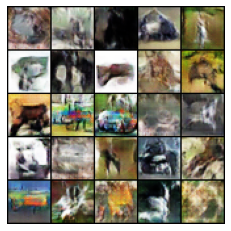

100%|██████████| 390/390 [08:58<00:00,  1.38s/it]


epoch 21, D_loss: 1.0608 G_loss: 1.3068


100%|██████████| 390/390 [08:52<00:00,  1.37s/it]


epoch 22, D_loss: 1.0477 G_loss: 1.3205


100%|██████████| 390/390 [08:57<00:00,  1.38s/it]


epoch 23, D_loss: 1.0359 G_loss: 1.3354


100%|██████████| 390/390 [08:47<00:00,  1.35s/it]


epoch 24, D_loss: 1.0487 G_loss: 1.3482


100%|██████████| 390/390 [08:43<00:00,  1.34s/it]

epoch 25, D_loss: 1.0371 G_loss: 1.3617


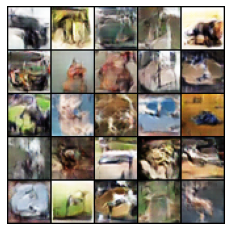

100%|██████████| 390/390 [08:36<00:00,  1.32s/it]


epoch 26, D_loss: 1.0399 G_loss: 1.3644


100%|██████████| 390/390 [09:09<00:00,  1.41s/it]


epoch 27, D_loss: 1.0329 G_loss: 1.3876


100%|██████████| 390/390 [09:15<00:00,  1.42s/it]


epoch 28, D_loss: 1.0489 G_loss: 1.3882


100%|██████████| 390/390 [09:12<00:00,  1.42s/it]


epoch 29, D_loss: 1.0028 G_loss: 1.4320


100%|██████████| 390/390 [09:12<00:00,  1.42s/it]

epoch 30, D_loss: 1.0328 G_loss: 1.4008


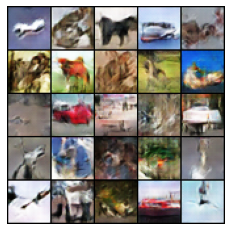

100%|██████████| 390/390 [09:12<00:00,  1.42s/it]


epoch 31, D_loss: 1.0115 G_loss: 1.4230


100%|██████████| 390/390 [09:12<00:00,  1.42s/it]


epoch 32, D_loss: 1.0221 G_loss: 1.4169


100%|██████████| 390/390 [09:09<00:00,  1.41s/it]


epoch 33, D_loss: 1.0237 G_loss: 1.4209


100%|██████████| 390/390 [09:12<00:00,  1.42s/it]


epoch 34, D_loss: 1.0073 G_loss: 1.4481


100%|██████████| 390/390 [09:10<00:00,  1.41s/it]

epoch 35, D_loss: 1.0060 G_loss: 1.4385


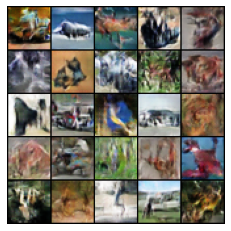

100%|██████████| 390/390 [09:09<00:00,  1.41s/it]


epoch 36, D_loss: 1.0070 G_loss: 1.4596


100%|██████████| 390/390 [14:25<00:00,  2.22s/it]


epoch 37, D_loss: 0.9852 G_loss: 1.4785


100%|██████████| 390/390 [18:40<00:00,  2.87s/it]   


epoch 38, D_loss: 0.9805 G_loss: 1.4976


100%|██████████| 390/390 [07:43<00:00,  1.19s/it]


epoch 39, D_loss: 0.9689 G_loss: 1.5328


100%|██████████| 390/390 [07:40<00:00,  1.18s/it]


epoch 40, D_loss: 0.9693 G_loss: 1.5286


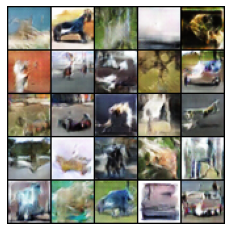

100%|██████████| 390/390 [07:41<00:00,  1.18s/it]


epoch 41, D_loss: 0.9618 G_loss: 1.5651


100%|██████████| 390/390 [07:41<00:00,  1.18s/it]


epoch 42, D_loss: 0.9515 G_loss: 1.5809


100%|██████████| 390/390 [07:39<00:00,  1.18s/it]


epoch 43, D_loss: 0.9493 G_loss: 1.5850


100%|██████████| 390/390 [07:39<00:00,  1.18s/it]


epoch 44, D_loss: 0.9607 G_loss: 1.5847


100%|██████████| 390/390 [07:39<00:00,  1.18s/it]

epoch 45, D_loss: 0.9705 G_loss: 1.5835


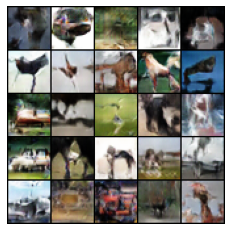

100%|██████████| 390/390 [07:38<00:00,  1.18s/it]


epoch 46, D_loss: 0.9359 G_loss: 1.6124


100%|██████████| 390/390 [07:39<00:00,  1.18s/it]


epoch 47, D_loss: 0.9357 G_loss: 1.6415


100%|██████████| 390/390 [07:38<00:00,  1.18s/it]


epoch 48, D_loss: 0.9320 G_loss: 1.6501


100%|██████████| 390/390 [07:38<00:00,  1.18s/it]


epoch 49, D_loss: 0.9296 G_loss: 1.6549


100%|██████████| 390/390 [07:40<00:00,  1.18s/it]

epoch 50, D_loss: 0.9094 G_loss: 1.6766


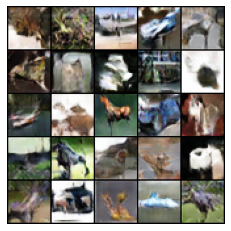

100%|██████████| 390/390 [07:39<00:00,  1.18s/it]


epoch 51, D_loss: 0.9211 G_loss: 1.6772


100%|██████████| 390/390 [07:39<00:00,  1.18s/it]


epoch 52, D_loss: 0.9107 G_loss: 1.7082


100%|██████████| 390/390 [07:39<00:00,  1.18s/it]


epoch 53, D_loss: 0.9092 G_loss: 1.7015


100%|██████████| 390/390 [07:39<00:00,  1.18s/it]


epoch 54, D_loss: 0.8925 G_loss: 1.7337


100%|██████████| 390/390 [07:41<00:00,  1.18s/it]

epoch 55, D_loss: 0.9076 G_loss: 1.7069


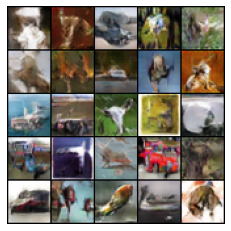

100%|██████████| 390/390 [07:41<00:00,  1.18s/it]


epoch 56, D_loss: 0.9054 G_loss: 1.7447


100%|██████████| 390/390 [07:43<00:00,  1.19s/it]


epoch 57, D_loss: 0.8849 G_loss: 1.7659


100%|██████████| 390/390 [07:41<00:00,  1.18s/it]


epoch 58, D_loss: 0.8917 G_loss: 1.7559


100%|██████████| 390/390 [07:40<00:00,  1.18s/it]


epoch 59, D_loss: 0.8730 G_loss: 1.7806


100%|██████████| 390/390 [07:40<00:00,  1.18s/it]

epoch 60, D_loss: 0.8610 G_loss: 1.8357


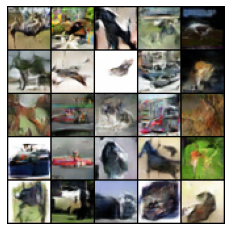

100%|██████████| 390/390 [07:40<00:00,  1.18s/it]


epoch 61, D_loss: 0.8708 G_loss: 1.8273


100%|██████████| 390/390 [07:39<00:00,  1.18s/it]


epoch 62, D_loss: 0.8576 G_loss: 1.8551


100%|██████████| 390/390 [07:40<00:00,  1.18s/it]


epoch 63, D_loss: 0.8681 G_loss: 1.8441


100%|██████████| 390/390 [07:40<00:00,  1.18s/it]


epoch 64, D_loss: 0.8521 G_loss: 1.8993


100%|██████████| 390/390 [07:40<00:00,  1.18s/it]

epoch 65, D_loss: 0.8271 G_loss: 1.8922


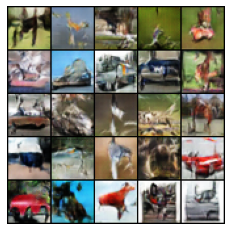

100%|██████████| 390/390 [07:41<00:00,  1.18s/it]


epoch 66, D_loss: 0.8410 G_loss: 1.8897


100%|██████████| 390/390 [07:40<00:00,  1.18s/it]


epoch 67, D_loss: 0.8270 G_loss: 1.9106


100%|██████████| 390/390 [07:40<00:00,  1.18s/it]


epoch 68, D_loss: 0.8277 G_loss: 1.9306


100%|██████████| 390/390 [07:40<00:00,  1.18s/it]


epoch 69, D_loss: 0.8436 G_loss: 1.9305


100%|██████████| 390/390 [07:39<00:00,  1.18s/it]

epoch 70, D_loss: 0.8125 G_loss: 1.9630


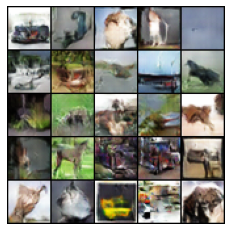

100%|██████████| 390/390 [07:39<00:00,  1.18s/it]


epoch 71, D_loss: 0.8279 G_loss: 1.9740


100%|██████████| 390/390 [07:39<00:00,  1.18s/it]


epoch 72, D_loss: 0.8171 G_loss: 1.9956


100%|██████████| 390/390 [07:39<00:00,  1.18s/it]


epoch 73, D_loss: 0.8182 G_loss: 1.9924


100%|██████████| 390/390 [07:39<00:00,  1.18s/it]


epoch 74, D_loss: 0.8442 G_loss: 1.9722


100%|██████████| 390/390 [07:39<00:00,  1.18s/it]


epoch 75, D_loss: 0.8048 G_loss: 2.0190


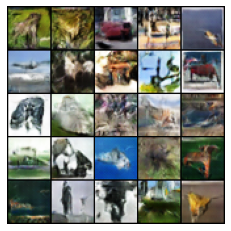

100%|██████████| 390/390 [07:41<00:00,  1.18s/it]


epoch 76, D_loss: 0.8190 G_loss: 2.0241


100%|██████████| 390/390 [07:42<00:00,  1.19s/it]


epoch 77, D_loss: 0.7742 G_loss: 2.0680


100%|██████████| 390/390 [07:42<00:00,  1.19s/it]


epoch 78, D_loss: 0.8041 G_loss: 2.0422


100%|██████████| 390/390 [07:41<00:00,  1.18s/it]


epoch 79, D_loss: 0.7919 G_loss: 2.0710


100%|██████████| 390/390 [07:41<00:00,  1.18s/it]

epoch 80, D_loss: 0.7977 G_loss: 2.0666


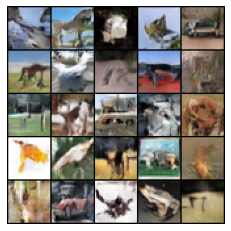

100%|██████████| 390/390 [07:40<00:00,  1.18s/it]


epoch 81, D_loss: 0.7827 G_loss: 2.1139


100%|██████████| 390/390 [07:40<00:00,  1.18s/it]


epoch 82, D_loss: 0.7806 G_loss: 2.1091


100%|██████████| 390/390 [07:41<00:00,  1.18s/it]


epoch 83, D_loss: 0.7897 G_loss: 2.0825


100%|██████████| 390/390 [07:41<00:00,  1.18s/it]


epoch 84, D_loss: 0.7707 G_loss: 2.1412


100%|██████████| 390/390 [07:40<00:00,  1.18s/it]

epoch 85, D_loss: 0.7885 G_loss: 2.1463


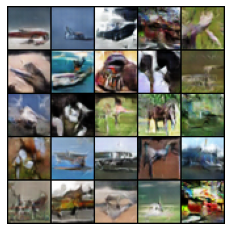

100%|██████████| 390/390 [07:41<00:00,  1.18s/it]


epoch 86, D_loss: 0.7736 G_loss: 2.1379


100%|██████████| 390/390 [07:40<00:00,  1.18s/it]


epoch 87, D_loss: 0.7875 G_loss: 2.1796


100%|██████████| 390/390 [07:42<00:00,  1.18s/it]


epoch 88, D_loss: 0.7684 G_loss: 2.1561


100%|██████████| 390/390 [07:41<00:00,  1.18s/it]


epoch 89, D_loss: 0.7723 G_loss: 2.2014


100%|██████████| 390/390 [07:42<00:00,  1.19s/it]

epoch 90, D_loss: 0.7979 G_loss: 2.1472


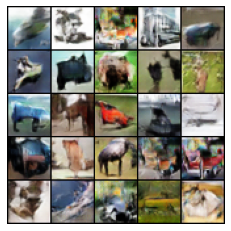

100%|██████████| 390/390 [07:41<00:00,  1.18s/it]


epoch 91, D_loss: 0.7618 G_loss: 2.1766


100%|██████████| 390/390 [07:41<00:00,  1.18s/it]


epoch 92, D_loss: 0.7569 G_loss: 2.2257


100%|██████████| 390/390 [07:40<00:00,  1.18s/it]


epoch 93, D_loss: 0.7638 G_loss: 2.1998


100%|██████████| 390/390 [07:41<00:00,  1.18s/it]


epoch 94, D_loss: 0.7643 G_loss: 2.2411


100%|██████████| 390/390 [07:41<00:00,  1.18s/it]

epoch 95, D_loss: 0.7760 G_loss: 2.1989


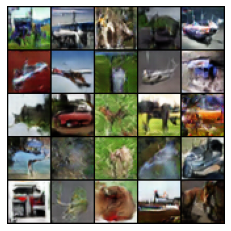

100%|██████████| 390/390 [07:41<00:00,  1.18s/it]


epoch 96, D_loss: 0.7627 G_loss: 2.2080


100%|██████████| 390/390 [07:41<00:00,  1.18s/it]


epoch 97, D_loss: 0.7446 G_loss: 2.2384


100%|██████████| 390/390 [07:41<00:00,  1.18s/it]


epoch 98, D_loss: 0.7625 G_loss: 2.2606


100%|██████████| 390/390 [07:41<00:00,  1.18s/it]


epoch 99, D_loss: 0.7520 G_loss: 2.2360


100%|██████████| 390/390 [07:39<00:00,  1.18s/it]

epoch 100, D_loss: 0.7469 G_loss: 2.2736


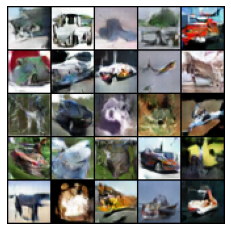

In [12]:
history = {}
history['D_loss'] = []
history['G_loss'] = []

for epoch in range(num_epochs):
    D_loss, G_loss, beta = train(D, G, D_criterion, G_criterion, D_optimizer, G_optimizer, data_loader, beta)
    
    print('epoch %d, D_loss: %.4f G_loss: %.4f' % (epoch + 1, D_loss, G_loss))
    history['D_loss'].append(D_loss)
    history['G_loss'].append(G_loss)
    
    # show
    if (epoch+1) % 5 == 0:
      generate(G)
    sleep(0.5) # for tqdm(?)

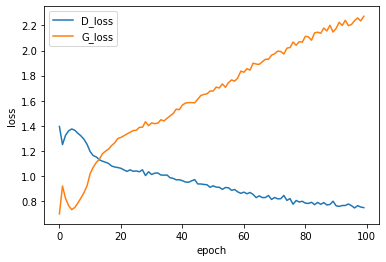

In [13]:
D_loss, G_loss = history['D_loss'], history['G_loss']
plt.plot(D_loss, label='D_loss')
plt.plot(G_loss, label='G_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [16]:
model_path = 'vgan_cifar10.pth'
torch.save(G.to('cpu').state_dict(), model_path)